# 32018 NLP Assignment 6 - Topic Modeling

**Prompt:**

You have been provided with a pickle file, containing 100 news articles about some company.  
Use appropriate topic modeling technique to identify top N most important topics.

* `read_pickle(directory+news_03.pkl')`
* Present top N most important topics in these news articles
* Select N to identify relevant topics, but minimize duplication
* Explain how you selected N

In [1]:
import time
import math
import re
from textblob import TextBlob
import pandas as pd

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import string

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis.gensim

## Read Data

In [2]:
directory = '~/Datasets/32018/'
file = 'webhose_cat.pkl'
path = directory + file

In [3]:
df = pd.read_pickle(path)
df.head()

,crawled,language,text,title,url
0,2018-01-30T18:28:45.012+02:00,english,Avery Dennison's (AVY) Q4 results are likely t...,IRobot downgraded to neutral from buy at Sidot...,http://omgili.com/ri/.wHSUbtEfZQRfU.5KUm1RkeXy...
1,2018-01-30T18:29:07.001+02:00,french,"1m95, c’est trop grand. Et sa stature, Bertran...","""Bertrand Zibi Abeghe, encore prisonnier, et t...",http://omgili.com/ri/.wHSUbtEfZTpzFtnXyQJIwJ.j...
2,2018-01-30T18:29:40.000+02:00,english,Tuggers and Topper Industrial Carts Help Trans...,Tuggers and Topper Industrial Carts Help Trans...,http://omgili.com/ri/jHIAmI4hxg.zDiulpymXqU_n4...
3,2018-01-30T18:30:05.007+02:00,english,Currently adding the following games:\n100 (by...,,http://omgili.com/ri/.0rSU5LtMgyggHgoOVy9TMDWT...
4,2018-01-30T18:30:05.013+02:00,english,Quote: : » Currently adding the following game...,,http://omgili.com/ri/.0rSU5LtMgyggHgoOVy9TMDWT...


## Clean the Data

In [4]:
df = df[df.language=='english']
df['text_clean'] = df['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))
df[['text', 'text_clean']].head(5)

,text,text_clean
0,Avery Dennison's (AVY) Q4 results are likely t...,Avery Dennisons AVY Q4 results are likely to g...
2,Tuggers and Topper Industrial Carts Help Trans...,Tuggers and Topper Industrial Carts Help Trans...
3,Currently adding the following games:\n100 (by...,Currently adding the following games:100 by ev...
4,Quote: : » Currently adding the following game...,Quote: : Currently adding the following games...
5,Quote: : » Currently adding the following game...,Quote: : Currently adding the following games...


In [5]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [6]:
news_clean = [clean(doc).split() for doc in df.text_clean.to_list()]
dictionary = corpora.Dictionary(news_clean)

%time doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_clean]

CPU times: user 28.8 ms, sys: 1.03 ms, total: 29.8 ms
Wall time: 31 ms


## Create the LDA Models

My strategy for picking the ideal number of topics is to generate several models with multiple topics and:  
  * 1) visually inspect them  
  * 2) use coherence scores

In [7]:
max_topics = 20
lda_models = []
n_topics = []

for i in range(1, max_topics):
    n_topics.append(i+1)
    %time model = LdaMulticore(doc_term_matrix, num_topics=i+1, id2word = dictionary, passes=50)
    lda_models.append(model)

CPU times: user 11.6 s, sys: 677 ms, total: 12.3 s
Wall time: 13 s
CPU times: user 10.6 s, sys: 601 ms, total: 11.2 s
Wall time: 11.7 s
CPU times: user 10.4 s, sys: 588 ms, total: 10.9 s
Wall time: 11.3 s
CPU times: user 14.4 s, sys: 1.2 s, total: 15.6 s
Wall time: 13.5 s
CPU times: user 17.2 s, sys: 1.57 s, total: 18.8 s
Wall time: 14.5 s
CPU times: user 16.6 s, sys: 1.52 s, total: 18.1 s
Wall time: 12.7 s
CPU times: user 16.8 s, sys: 1.51 s, total: 18.3 s
Wall time: 12.7 s
CPU times: user 16.7 s, sys: 1.5 s, total: 18.2 s
Wall time: 12.5 s
CPU times: user 16.3 s, sys: 1.46 s, total: 17.8 s
Wall time: 12.2 s
CPU times: user 17.4 s, sys: 1.63 s, total: 19.1 s
Wall time: 12.4 s
CPU times: user 18.1 s, sys: 1.72 s, total: 19.8 s
Wall time: 13.9 s
CPU times: user 17.7 s, sys: 1.66 s, total: 19.4 s
Wall time: 13.1 s
CPU times: user 17.7 s, sys: 1.65 s, total: 19.4 s
Wall time: 12.9 s
CPU times: user 18.1 s, sys: 1.7 s, total: 19.8 s
Wall time: 13.3 s
CPU times: user 18.4 s, sys: 1.85 s, to

There are too many models to inspect all of them, so we'll just look at a few.

In [8]:
print(lda_models[0].print_topics(num_topics=i, num_words=5))
print()
print(lda_models[4].print_topics(num_topics=i, num_words=5))
print()
print(lda_models[9].print_topics(num_topics=i, num_words=5))
print()

[(0, '0.008*"plant" + 0.008*"company" + 0.006*"caterpillar" + 0.006*"share" + 0.005*"amazon"'), (1, '0.007*"tax" + 0.006*"market" + 0.005*"u" + 0.004*"state" + 0.004*"city"')]

[(0, '0.015*"inc" + 0.010*"jan" + 0.008*"blade" + 0.007*"skid" + 0.006*"pusher"'), (1, '0.017*"plant" + 0.012*"market" + 0.010*"case" + 0.006*"wardian" + 0.005*"terrarium"'), (2, '0.007*"new" + 0.006*"company" + 0.006*"health" + 0.005*"caterpillar" + 0.004*"forklift"'), (3, '0.016*"tax" + 0.012*"u" + 0.008*"sphere" + 0.007*"amazon" + 0.007*"seattle"'), (4, '0.018*"market" + 0.011*"city" + 0.010*"state" + 0.010*"median" + 0.010*"estimate"'), (5, '0.012*"share" + 0.012*"company" + 0.011*"caterpillar" + 0.007*"jan" + 0.007*"product"')]

[(0, '0.017*"house" + 0.007*"like" + 0.005*"program" + 0.005*"food" + 0.005*"home"'), (1, '0.025*"sphere" + 0.024*"amazon" + 0.022*"seattle" + 0.013*"monday" + 0.013*"grand"'), (2, '0.018*"cart" + 0.014*"topper" + 0.012*"industrial" + 0.009*"material" + 0.008*"line"'), (3, '0.017*"m

In [9]:
lda_display2 = pyLDAvis.gensim.prepare(lda_models[0], doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display2)

/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


With only two topics, the areas covered are so broad that the only way to describe them is to use lots of "and". Topic 1 articles are about the overall market AND taxes. Topic two is about Catapiller AND Amazon AND share prices. This is too few topics because they are not distinct enough.

In [10]:
lda_display5 = pyLDAvis.gensim.prepare(lda_models[3], doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display5)

/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


This is a more reasonable number of topics. Clearly delinieated, large bubbles that don't overlap. They are reasonably interpretable as well. I am tempted to just pick this as the number of topics, but it is worthwhile to find a more systematic way of picking the number of topics.

In [11]:
lda_display20 = pyLDAvis.gensim.prepare(lda_models[-1], doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display20)

/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


There are now probably too many models. Some bubbles start to overlap, and some topics are too small with only a handful of articles. We want all the topics to be reasonabley large or else the interpretation isn't valuable.

## Coherence Scores

Coherence Scores is a tool that can be used to evaluate a topic model. It is a measure of the probabilities that words within an article get are assigned topic that contain that word. Generally higher coherence is better, but we still want the topics to be distinct enough that they do not overlap and are dominated by a few words for interpretability. A great coherence score isn't worth much if the topic cannot be explained easily.

In [12]:
coherence_scores = []

for model in lda_models:
    coherencemodel = CoherenceModel(model=model, texts=news_clean, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherencemodel.get_coherence())

[Text(0, 0.5, 'Coherence Score'), Text(0.5, 0, 'Number of Topics')]

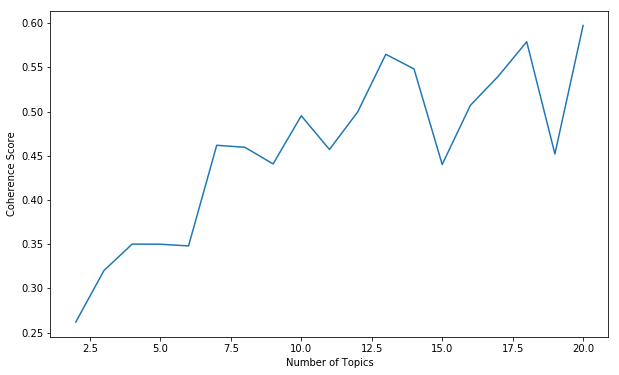

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x=n_topics, y=coherence_scores, ax=ax)
ax.set(xlabel='Number of Topics', ylabel='Coherence Score')

Coherence generally improves with the number of topics, however it seems to start to level out after 13 topics. While 20 topics technically has a better score, we saw from looking at the 20 topic LDA display that too many topics overwhelms the interpretablilty. 

## Final Model -- Number of Topics = 13

In [23]:
lda_models[11].print_topics(num_words=5)

[(0,
  '0.010*"automation" + 0.007*"hp" + 0.007*"execution" + 0.007*"testing" + 0.006*"alm"'),
 (1,
  '0.012*"company" + 0.011*"health" + 0.009*"new" + 0.008*"robot" + 0.007*"care"'),
 (2,
  '0.015*"cart" + 0.014*"house" + 0.011*"topper" + 0.010*"industrial" + 0.009*"material"'),
 (3,
  '0.011*"grader" + 0.007*"caterpillar" + 0.006*"u" + 0.006*"construction" + 0.006*"also"'),
 (4,
  '0.025*"sphere" + 0.024*"amazon" + 0.022*"seattle" + 0.013*"monday" + 0.013*"grand"'),
 (5,
  '0.019*"inc" + 0.014*"caterpillar" + 0.013*"share" + 0.013*"company" + 0.012*"jan"'),
 (6,
  '0.026*"tax" + 0.018*"u" + 0.011*"china" + 0.010*"repatriation" + 0.008*"would"'),
 (7,
  '0.037*"plant" + 0.023*"case" + 0.013*"wardian" + 0.012*"terrarium" + 0.010*"care"'),
 (8,
  '0.012*"median" + 0.012*"city" + 0.011*"estimate" + 0.010*"university" + 0.010*"2017"'),
 (9,
  '0.009*"bucket" + 0.007*"caterpillar" + 0.007*"new" + 0.007*"manufacturing" + 0.006*"excavator"'),
 (10,
  '0.045*"market" + 0.014*"industry" + 0.01

In [24]:
lda_display13 = pyLDAvis.gensim.prepare(lda_models[11], doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display13)

/Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
